In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Encoding a signal into multiple frequencies sawtooth signals.

We are generating trajectories (here each trajectory is 2D), and data that simulate sensor observations of these trajectories. Then the goal will be to build a model that map the observation to the trajectories so that if we are given only the sensor data we can reconstruct the trajectories.

## 1.1 Generating the trajectories.

In [2]:
# Number of time steps in the signal to record (here the signal is a 2D trajectory in the velcoity space)
L_SIGNAL = 1000

# Seed of the trajectory.
V0 = [-1, 0.25]

# Temporal inertia of the trajectory.
A = np.array([0.9, 0.9])

# Noise covariance: diagonal matrix = independent noise. We put more noise on the 2nd component.
W = np.diag([0.5, 0.75])

In [3]:
def gen_trace(v0=V0, l_signal=L_SIGNAL):
    """Generate the random trajectory from the seed v0. Return an array of shape (L_SIGNAL, v0).
    """
    x = [v0]
    dim = len(v0)
    for k in range(1, l_signal):
        noise = np.random.multivariate_normal(np.zeros(dim), W)
        x_k = A*x[k-1] + noise        
        x.append(x_k)
    return np.array(x)

In [4]:
# Generate a trajectory to train the model and one trajectory to test it with the same seed.
V_train = gen_trace()
V_test = gen_trace()

## 1.2 Generating the encoding signal.

In [5]:
# Number of measurements per trajectory point (the length of the sensor data will be n_sample * L_SIGNAL)
n_sample = 100

# Biais of the encoder.
encoder_biais = 20

# Noise of the encoder.
encoder_noise = 4

# Combination of the trajectories that will be encoded ([1, 1] <-> vx + vy) 
tuning_directions = [
    np.array([1, 1]), 
    np.array([-1, 1]),
    np.array([-1, -1]), 
    np.array([1, -1]),    
]

# Sawtooth signal on which to encode each combination.
templates = np.array([
    np.array([x % (100/3) for x in np.arange(n_sample)]),
    np.array([x % (100/5) for x in np.arange(n_sample)]),
    np.array([x % (100/9) for x in np.arange(n_sample)]),
    np.array([x % (100/11) for x in np.arange(n_sample)]),
])

n_features = len(tuning_directions)

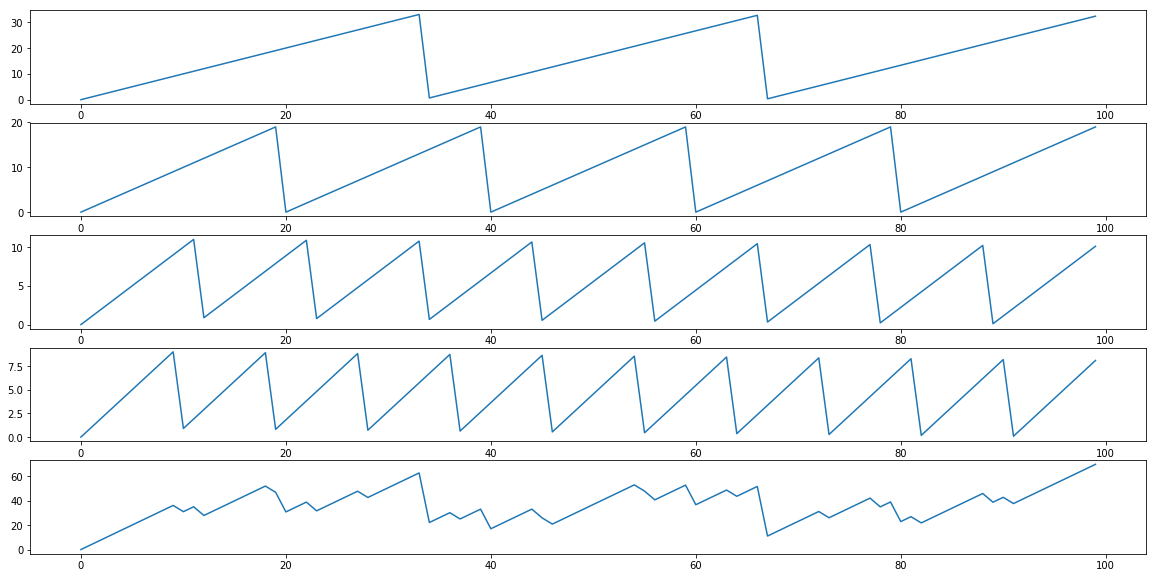

In [6]:
fig, axes = plt.subplots(5,1, figsize=(20,10))
for k in range(4):
    axes[k].plot(templates[k])
axes[4].plot(templates.sum(0))

In [7]:
# Generate the sensor data from the trajectory.
def gen_simulated_features(x):
    l_signal = len(x)
    features = []
    for k in range(l_signal):
        noise_encoder = np.random.normal(loc=encoder_biais, scale=encoder_noise, size=n_features)
        gain = tuning_directions @ x[k] + noise_encoder
        features.append(gain @ templates)        
    return np.concatenate(features)

In [8]:
obs_train = gen_simulated_features(V_train)
obs_test = gen_simulated_features(V_test)

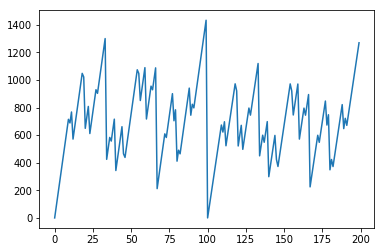

In [9]:
plt.plot(obs_train[:200])

# 2. Decoding the sensor signal: Answer of the case study

Let's assume that we have no idea how the sensor signal was generated and we try to retrieve the trajectory. We only have the data:

- Training set: trajectory 'V_train' (1000, 2) and sensor observation 'obs_train' (100000)
- Testing set: trajectory 'V_test' (1000, 2) and sensor observation 'obs_test' (100000)

and this indication: "The object moves every 100ms, and we have 100 sensor data points for every change in trajectory".


In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import pearsonr
import pywt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score

In [11]:
def estimated_autocorrelation(x):
    """Return the corrected estimated auto-correlation coefficients of signal x.
    For reference see:
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def smooth(y, window_length=17, polyorder=2):
    """Apply a Savitzy-Golay filter on the signal y to smooth it. If used on a matrix Y of dim (n, m),
    this function will return a matrix Y_smooth of dim (n, m) where each column vector (dim=m) correspond
    to each column vector of Y that has been smoothed.
    """
    try:
        n_signal = y.shape[1]
        y_smooth = np.zeros((len(y), n_signal))
        for i in range(n_signal):
            yi = y[:, i]
            y_smooth[:, i] = signal.savgol_filter(yi, window_length=window_length, polyorder=polyorder)
    except:
        y_smooth = signal.savgol_filter(y, window_length=window_length, polyorder=polyorder)
    return y_smooth

## 2.1 Data Exploration

As we (supposedly) know nothing of our data, let's explore it through few plots.

### 2.1.1. For the sensor measurement (the input variable).

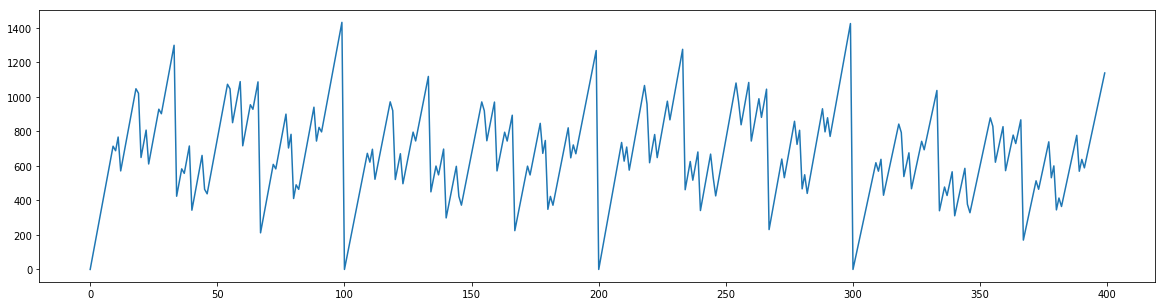

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(obs_train[:400])

The sensor data seems to be very auto-correlated, with a big peak every 100 samples: that correspond to 100ms which is the sampling frequency of the real trajectory, let's compute the auto-correlation coefficients.

In [13]:
ACF_obs_train = estimated_autocorrelation(obs_train[:2000])

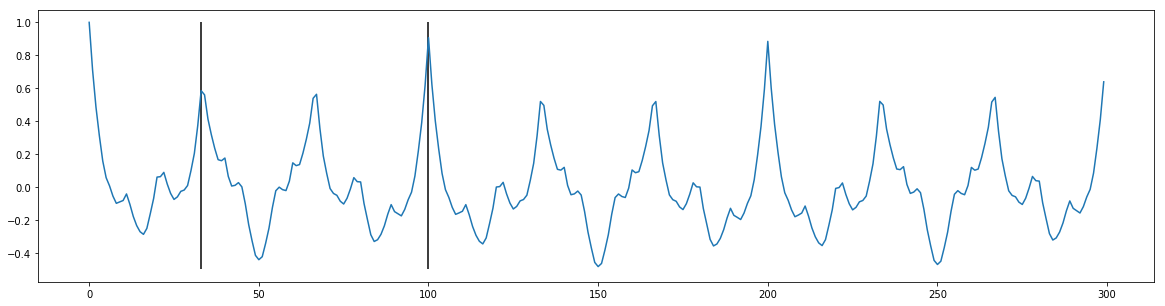

In [14]:
plt.figure(figsize=(20,5))
plt.plot(ACF_obs_train[:300])
plt.vlines(x=[33, 100], ymin=-0.5, ymax=1.)

We confirm the very high auto-correlation at 100 samples (which delimites every sensor acquisition) and we also see a pretty stron auto-correlation at 33 samples (that correspond to the sawtooth component with the biggest amplitude). This auto-correlation at a sub-acquisition scale (<100) should give us the first clue that the signal is encoded by its frequence. Therefore it might be a good idea to pre-process the signal to obtain frequential dependent features.

### 2.1.2. For the velocity (the target variable).

In [15]:
df_train = pd.DataFrame(data=V_train, columns=['vx','vy'])
vx_train = V_train[:, 0]
vy_train = V_train[:, 1]

In [16]:
df_test = pd.DataFrame(data=V_test, columns=['vx','vy'])
vx_test = V_test[:, 0]
vy_test = V_test[:, 1]

In [17]:
df_train.describe()

,vx,vy
count,1000.000000,1000.000000
mean,0.142450,-0.639581
std,1.681795,1.916709
min,-4.818278,-6.149645
25%,-1.004819,-1.998708
50%,0.070350,-0.673106
75%,1.368300,0.686706
max,5.405041,4.555463


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


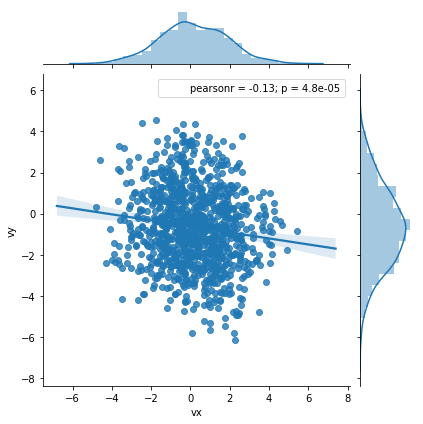

In [18]:
g = sns.jointplot("vx", "vy", data=df_train, kind='reg')
g.annotate(pearsonr)
plt.show()

We see here that the two velocity variables are not correlated (as we generate them independent, it makes sense). Let's have a quick view of the two trajectories below (vx in blue and vy in orange)

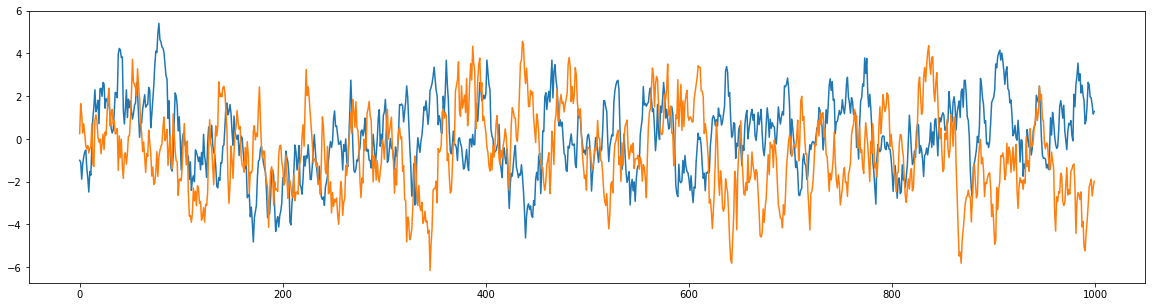

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(vx_train)
plt.plot(vy_train)

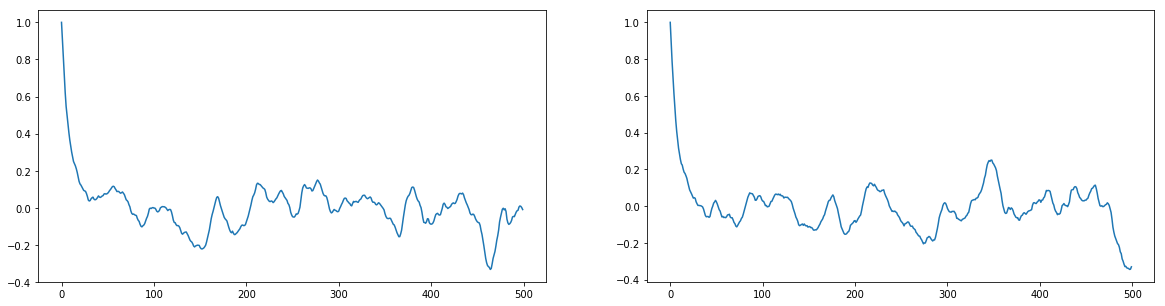

In [20]:
ACF_vx_train = estimated_autocorrelation(vx_train)
ACF_vy_train = estimated_autocorrelation(vy_train)
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(ACF_vx_train[:500])
ax[1].plot(ACF_vy_train[:500])

The velocity are not very auto-correlated (logical as we simulate a brownian motion).

From our exploration of the data, and the instructions we restructure the data so that the sensor observation is now a (1000, 100) matrix with 1000 observations of a 100 features that we are going to map to the 2 outputs: vx and vy.

In [21]:
#lobs = len(obs_train)
obs_train_reshape = np.array([obs_train[i*100:(i+1)*100] for i in range(L_SIGNAL)])
obs_test_reshape = np.array([obs_test[i*100:(i+1)*100] for i in range(L_SIGNAL)])

The objective is now to do some feature engineering (compute other features manually from these 100 features), model selection and optimization to get the best mapping between the sensor observations and the trajectories.

## 2.2 Predictive model

In [22]:
### Some helper functions.

def relRMSE(y_real, y_predicted):
    """Compute a relative and dimensionless RMSE defined by: 
    RMSE(y_real, y_predicted) / sqrt(|<y_real> . <y_predicted>|)
    """
    RMSE = np.sqrt(((y_real - y_predicted)**2).sum() / len(y_real))
    return RMSE/ np.sqrt(np.abs(y_real.mean() * y_predicted.mean()))

def print_score(input_train, input_test, output_train_est, output_test_est):
    """Display both the R2 score and the relRMSE for both training and testing set"""
    vx_train_est = output_train_est[:, 0]
    vy_train_est = output_train_est[:, 1]

    vx_test_est = output_test_est[:, 0]
    vy_test_est = output_test_est[:, 1]
    
    print(f'vx_train, r2: {r2_score(vx_train, vx_train_est)}, relRMSE: {relRMSE(vx_train, vx_train_est)}')
    print(f'vy_train, r2: {r2_score(vy_train, vy_train_est)}, relRMSE: {relRMSE(vy_train, vy_train_est)}')
    
    print(f'vx_test, r2: {r2_score(vx_test, vx_test_est)}, relRMSE: {relRMSE(vx_test, vx_test_est)}')
    print(f'vy_test, r2: {r2_score(vy_test, vy_test_est)}, relRMSE: {relRMSE(vy_test, vy_test_est)}')
    
def variance_inflation_factor(X, X_idx):
    """Compute the VIF on the inputs X, of the feature x_i = X[:, X_idx] 
    X : ndarray, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression
    X_idx : int
        index of the X_idxth variable in the columns of X
    """
    k_vars = X.shape[1]
    x_i = X[:, X_idx]
    mask = np.arange(k_vars) != X_idx
    x_noti = X[:, mask]
    #r_squared_i = OLS(x_i, x_noti).fit().rsquared
    reg = LinearRegression().fit(x_noti, x_i)
    r_squared_i = reg.score(x_noti, x_i)
    if r_squared_i == 1.:
        vif = float('inf')
    else:
        vif = 1. / (1. - r_squared_i)
    return vif


### 2.2.1 Naive model: predict with the raw sensor value

In [23]:
# Smoothing the obs before training (can inrease R2 of more than 50%!).
input_train = smooth(obs_train_reshape)
input_test = smooth(obs_test_reshape)

In [24]:
### Scaling the data.
scaler  = StandardScaler().fit(input_train)
input_train  = scaler.transform(input_train)
input_test  = scaler.transform(input_test)

In [25]:
# Linear Regression with L2 regularization (Regularization also improves a lot result on testing set here).
reg = Ridge()
reg.fit(input_train, V_train)
V_train_est = reg.predict(input_train)
V_test_est = reg.predict(input_test)

In [26]:
print_score(input_train, input_test, V_train_est, V_test_est)

vx_train, r2: 0.6701950159572336, relRMSE: 6.776750530334717
vy_train, r2: 0.7195611424182131, relRMSE: 1.5862164255099622
vx_test, r2: 0.6526465489606731, relRMSE: 4.400024940581427
vy_test, r2: 0.744907556077401, relRMSE: 3.710347909455339


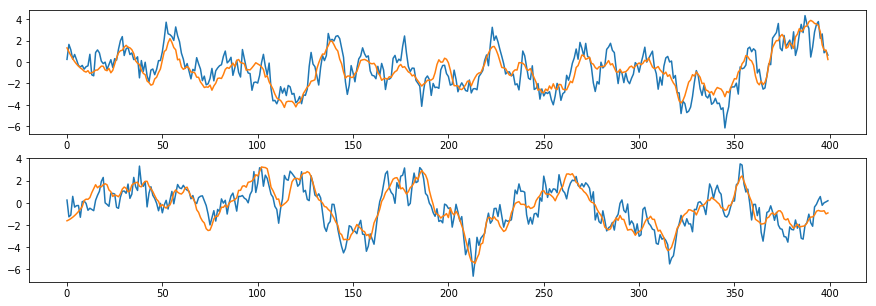

In [27]:
fig, ax = plt.subplots(2, figsize=(15,5))
ax[0].plot(V_train[:, 1][:400])
ax[0].plot(V_train_est[:, 1][:400])
ax[1].plot(V_test[:, 1][:400])
ax[1].plot(V_test_est[:, 1][:400])

We get already pretty good results with the naive model (smoothing the observations improves drastically the results).

In [28]:
vif_features = [variance_inflation_factor(input_train, i) for i in range(input_train.shape[1])]

In [29]:
min(vif_features)

inf

However the features are highly correlated (as we could expect), so we can compress the model and use less features that are more relevant features. Ideally we should be able to reduce the dimensionality to 4 (since the observation signal has been encoded in 4 dimensions).

For this PCA can be used, but as we noticed in the data exploration, a spectral analysis might also be a good idea 

### 2.2.2 PCA

In [30]:
# Smoothing the obs before training (can inrease R2 of more than 50%!).
input_train = smooth(obs_train_reshape)
input_test = smooth(obs_test_reshape)

In [31]:
### Scaling the data.
scaler  = StandardScaler().fit(input_train)
input_train  = scaler.transform(input_train)
input_test = scaler.transform(input_test)

In [32]:
pca = PCA(n_components=4)
input_train = pca.fit_transform(input_train)
input_test = pca.fit_transform(input_test)

In [33]:
# Linear Regression with L2 regularization (Regularization also improves a lot result on testing set here).
reg = Ridge()
reg.fit(input_train, V_train)
V_train_est = reg.predict(input_train)
V_test_est = reg.predict(input_test)

In [34]:
print_score(input_train, input_test, V_train_est, V_test_est)

vx_train, r2: 0.6701950159572336, relRMSE: 6.776750530334721
vy_train, r2: 0.7195611424182131, relRMSE: 1.5862164255099622
vx_test, r2: -1.8673075213757215, relRMSE: 16.95393626103123
vy_test, r2: 0.6869513631193824, relRMSE: 2.9885586509075845


We observe, that the PCA (as I used it here) is not efficient to reduce the dimensionality of the problem. Let's try to see if we can use a frequential analysis for this purpose.

### 2.2.3 Spectral components

### Fourrier

In [35]:
# Compute the Fourrier components
fourrier_train  = np.array([np.fft.fft(obs_i) for obs_i in obs_train_reshape])
fourrier_test = np.array([np.fft.fft(obs_i) for obs_i in obs_test_reshape])

In [36]:
# Return the average of the fourrier coefficients at different bands.
n_bands = 4

def get_average_freq(y, n_bands):
    l_signal = len(y)
    n_coeff = l_signal // (n_bands * 2)
    bank_average_coeff = [np.mean(y[i * n_coeff:(i+1) * n_coeff]) for i in range(n_bands)]
    return np.abs(bank_average_coeff)
    

In [37]:
fourrier_train_amp = np.zeros((1000, n_bands))
for i in range(len(input_train)):
    fourrier_train_amp[i, :] = get_average_freq(fourrier_train[i], n_bands)
    
fourrier_test_amp = np.zeros((1000, n_bands))
for i in range(len(input_test)):
    fourrier_test_amp[i, :] = get_average_freq(fourrier_test[i], n_bands)

In [38]:
input_train = fourrier_train_amp
input_test = fourrier_test_amp

In [39]:
### Scaling the data.
scaler  = StandardScaler().fit(input_train)
input_train  = scaler.transform(input_train)
input_test  = scaler.transform(input_test)

In [40]:
input_train = smooth(input_train)
input_test = smooth(input_test)

In [41]:
# Linear Regression with L2 regularization.
reg = Ridge().fit(input_train, V_train)
V_train_est = reg.predict(input_train)
V_test_est = reg.predict(input_test)

In [42]:
# Fourrier only
print_score(input_train, input_test, V_train_est, V_test_est)

vx_train, r2: 0.5953246012668079, relRMSE: 7.506652171699413
vy_train, r2: 0.6857692970913952, relRMSE: 1.679065570978115
vx_test, r2: 0.5987886540034253, relRMSE: 6.568313030216352
vy_test, r2: 0.7146011788164963, relRMSE: 4.124588407395129


In [43]:
vif_hist = [variance_inflation_factor(input_train, i) for i in range(input_train.shape[1])]

In [44]:
print(vif_hist)

[2151.10119444974, 346.70257306320707, 127.51081653158484, 438.6402353986249]


We get a reasonable score but the score decreases and the vif is still pretty high (showing that the features are highly correlated and are capturing common information).

This might come from the fact that the Fourrier transform of a sawtooth signal is not as straitforward as the fourrier transform of sinusoids. 

Let's try to achieve this result using wavelets that might be better at decomposing a sawtooth signal (if we use the right wavelet).

### Wavelets 

In [45]:
wavelet_train_coeff = np.array([pywt.wavedec(acq, "db4", mode="symmetric") for acq in obs_train_reshape])
wavelet_train_amp = np.array([[coeff_i.mean() for coeff_i in coeffs_t] for coeffs_t in wavelet_train_coeff])

In [46]:
wavelet_test_coeff = np.array([pywt.wavedec(acq, "db4", mode="symmetric") for acq in obs_test_reshape])
wavelet_test_amp = np.array([[coeff_i.mean() for coeff_i in coeffs_t] for coeffs_t in wavelet_test_coeff])

In [47]:
input_train = wavelet_train_amp
input_test = wavelet_test_amp

In [48]:
### Scaling the data.
scaler  = StandardScaler().fit(input_train)
input_train  = scaler.transform(input_train)
input_test  = scaler.transform(input_test)

In [49]:
input_train = smooth(input_train)
input_test = smooth(input_test)

In [50]:
# Linear Regression with L2 regularization.
reg = Ridge().fit(input_train, V_train)
V_train_est = reg.predict(input_train)
V_test_est = reg.predict(input_test)

In [51]:
# Score
print_score(input_train, input_test, V_train_est, V_test_est)

vx_train, r2: 0.6680946754726071, relRMSE: 6.798294919915616
vy_train, r2: 0.7177635530324278, relRMSE: 1.591292061545159
vx_test, r2: 0.6558409067722737, relRMSE: 4.473887242124317
vy_test, r2: 0.7444176485632565, relRMSE: 3.6605461203248084


In [52]:
vif_hist = [variance_inflation_factor(input_train, i) for i in range(input_train.shape[1])]

In [53]:
print(vif_hist)

[22.5867231947694, 1.9761102235946881, 17.609672524823047, 10.279034726233217]


Here we get the same score by compressing the model to only 4 coefficients (which is the minimum of coefficients we expect to need from how we simulate the data sensor). Let's see what the trajectory looks like.

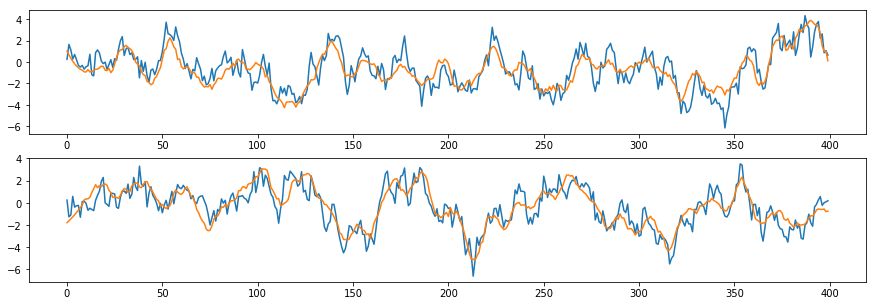

In [54]:
fig, ax = plt.subplots(2, figsize=(15,5))
ax[0].plot(V_train[:, 1][:400])
ax[0].plot(V_train_est[:, 1][:400])
ax[1].plot(V_test[:, 1][:400])
ax[1].plot(V_test_est[:, 1][:400])

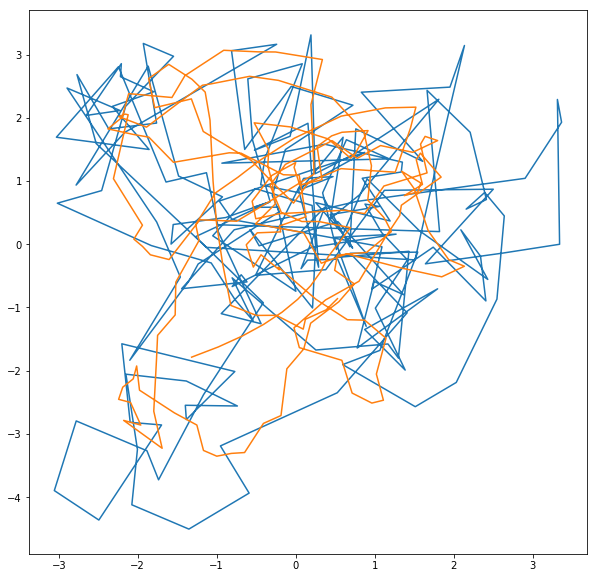

In [55]:
plt.figure(figsize=(10,10))
plt.plot(V_test[:200, 0], V_test[:200, 1])
plt.plot(V_test_est[:200, 0], V_test_est[:200, 1])

We note that the predicted trajectory looks good in 1D (vx Vs vx_est) but it is not very satisfying if we plot it in the 2D space. To further improve the quality of our model, we could play on the hyperparameters (smoothing, regularization, type of wavelets, ...) as well as on the model itself (random forest, NNs,...).

One should also note, that by rerunning this notebook (and therefore generating diffferent random trajectories and observation signals), we get significantly different score but that the interpretation stays valid (in the trials that I have ran at least).